In [1]:
# generic
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import missingno as msno
# sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, LeaveOneOut, ShuffleSplit, LeaveOneGroupOut, StratifiedGroupKFold, StratifiedShuffleSplit, GroupShuffleSplit, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, matthews_corrcoef, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, RidgeClassifier, ElasticNetCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, f_classif, SelectFromModel, RFECV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF
# keras to create ANN
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
!pip install scikeras
from scikeras.wrappers import KerasClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### FS library setup

In [87]:
!git clone https://github.com/EESI/PyFeast.git

fatal: destination path 'PyFeast' already exists and is not an empty directory.


In [109]:
!python PyFeast/setup.py build

/content/PyFeast/setup.py:1: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.core import setup
running build
running build_py


In [89]:
!chmod +rwx build/lib/PyFeast/feast.py

In [136]:
!python build/lib/PyFeast/feast.py

Traceback (most recent call last):
  File "/content/build/lib/PyFeast/feast.py", line 24, in <module>
    libFSToolbox = c.CDLL("libFSToolbox.so"); 
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: libFSToolbox.so: cannot open shared object file: No such file or directory


In [131]:
!sudo python PyFeast/setup.py install

python3: can't open file '/content/MIToolbox/PyFeast/setup.py': [Errno 2] No such file or directory


In [11]:
%cd ..

/content


In [17]:
%cd PyFeast

/content/PyFeast


In [19]:
!ls

feast.py	 LICENSE.txt  README.markdown  test
libMIToolbox.so  __pycache__  setup.py


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd MIToolbox

/content/MIToolbox


In [14]:
!mv /content/drive/MyDrive/libMIToolbox.so /content/PyFeast

In [7]:
!make

make: 'libMIToolbox.so' is up to date.


In [6]:
import torch

In [18]:
!python feast.py

Traceback (most recent call last):
  File "/content/PyFeast/feast.py", line 24, in <module>
    libFSToolbox = c.CDLL("libFSToolbox.so"); 
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: libFSToolbox.so: cannot open shared object file: No such file or directory


In [20]:
from feast.py import DISR

OSError: ignored

## methods

In [2]:
def find_zscore_outliers(df, col_name, bottom_threshold=-9, top_threshold=9):
  global zscore_outliers
  global zscore_non_outliers

  mean = np.mean(df[col_name])
  mad = df[col_name].mad()

  zscore_outliers = [x for x in df[col_name] if (
    ((x-mean)/mad < bottom_threshold) or ((x-mean)/mad > top_threshold))]
  zscore_non_outliers = [x for x in df[col_name] if (
    ((x-mean)/mad < top_threshold) & ((x-mean)/mad > bottom_threshold))]

  outlier_filtered_zscore = df.loc[df[col_name].isin(zscore_outliers)]
  filtered_zscore = df.loc[df[col_name].isin(zscore_non_outliers)]

  print(f"{col_name} - {outlier_filtered_zscore.index}")
  final_outliers.append(outlier_filtered_zscore.index)

In [3]:
def get_outlier_count(outliers) :
  count = 0
  unique_outliers_manual = []
  for outlier_list in outliers:
    for outlier in outlier_list:
      unique_outliers_manual.append(outlier)
      count = count + 1
  # total number of outliers found
  print("total number of outliers: " + str(count))
  unique_outliers_manual = np.unique(unique_outliers_manual)
  # number of unique outlier indexes
  print("number of unique outliers: " + str(unique_outliers_manual.size))
  print(unique_outliers_manual)

In [4]:
def create_baseline():
 # create model
 model = Sequential()
 model.add(Dense(160, input_shape=(160,), activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

In [5]:
# get a list of models to evaluate
def get_models():
 models = dict()
 models['knn'] = KNeighborsClassifier()
 models['dt'] = DecisionTreeClassifier()
 models['rf'] = RandomForestClassifier()
 models['et'] = ExtraTreesClassifier()
 models['l_svm'] = LinearSVC()
 models['svm'] = SVC(kernel='linear')
 models['bayes'] = GaussianNB()
 models['lr'] = LogisticRegression(max_iter=1000)
 models['en'] = LogisticRegression(penalty = 'elasticnet', solver='saga', l1_ratio = 0.5, max_iter=1000)
 models['lda'] = LinearDiscriminantAnalysis()
 models['ridge'] = RidgeClassifier()
 return models

In [6]:
# get a list of cross-validation methods to evaluate
def get_cvs():
  cvs = dict()
  cvs['RSK'] = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=1)
  cvs['LOO'] = LeaveOneOut()
  cvs['SSS'] = StratifiedShuffleSplit(n_splits=10)
  cvs['SS'] = ShuffleSplit(n_splits=10, test_size=0.3)
  return cvs

In [7]:
def performance_metrics(model, y_test, y_pred):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=1)
  # [ TN / FN ]
  # [ FP / TP ]
  print("=== Confusion Matrix ===")
  print(confusion_matrix(y_test, y_pred))
  print("=== Classification Report ===")
  print(classification_report(y_test, y_pred))
  print("=== Metrics ===")
  auc_score = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
  print("%.3f" % auc_score.mean())
  acc_score = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
  print("%.3f" % acc_score.mean())
  f1_score = cross_val_score(model, X, y, cv=cv, scoring='f1')
  print("%.3f" % f1_score.mean())  
  se_score = cross_val_score(model, X, y, cv=cv, scoring='recall')
  print("%.3f" % se_score.mean())
  print("%.3f" % recall_score(y_test, y_pred, pos_label=0))
  mcc_score = cross_val_score(model, X, y, cv=cv, scoring='matthews_corrcoef')
  print("%.3f" % mcc_score.mean())

## RPPA Preprocessing/EDA

### loading data

In [ ]:
c_df = pd.read_csv("/content/sample_data/clinical.txt", sep="\t")
c_df.set_index("participant", inplace=True)

In [ ]:
p_df = pd.read_csv("/content/sample_data/protein.txt", sep="\t")
# each column is a tissue sample
# each row is a protein
# therefore each cell represents the level of the specific protein in that specific tissue sample.

### separating X and y

In [ ]:
# dataframe with participant number index and pfi column
pfi_df = pd.DataFrame(data=c_df.pfi)
# make index the participant number
p_df.set_index("Sample REF", inplace=True)
transpose_df = p_df.transpose()
# merge clinical pfi result and protein data
merged_df = transpose_df.merge(pfi_df, how="inner", on=transpose_df.index)
merged_df.set_index("key_0", inplace=True)
merged_df

,14-3-3_epsilon,4E-BP1,4E-BP1_pS65,4E-BP1_pT37T46,4E-BP1_pT70,53BP1,ACC1,ACC_pS79,AMPK_alpha,AMPK_pT172,...,p27_pT157,p27_pT198,p38_MAPK,p38_pT180_Y182,p53,p63,p70S6K,p70S6K_pT389,p90RSK_pT359_S363,pfi
key_0,,,,,,,,,,,,,,,,,,,,,
4074,-0.975455,-0.344284,0.461891,1.795396,1.763210,0.940777,2.529120,-0.673478,1.312644,-0.470337,...,1.252789,0.107269,0.516851,0.000823,0.459285,1.816838,0.191172,-2.191290,-0.743105,0
4078,-1.023625,0.335990,-0.042486,1.065434,0.595061,1.315773,2.119877,-0.878761,1.848433,2.194422,...,0.400928,0.155596,1.030774,1.941106,0.071299,2.852411,0.484189,-2.548276,-0.337144,1
5149,-0.656239,1.112516,0.524127,0.412476,1.085620,1.450957,1.806726,-1.032176,0.710373,1.551747,...,0.740280,-0.221206,0.563064,0.724724,0.577707,2.276514,-0.102408,-2.401650,-1.125616,1
5151,-0.417939,1.837359,0.363827,0.262011,1.287822,0.978116,2.832971,-0.122219,1.584088,1.813148,...,0.786717,-0.091238,0.786525,0.735234,0.293831,2.273316,0.230295,-2.180772,-1.328046,0
5152,-0.771338,1.386950,0.059264,0.576787,0.821192,0.813838,3.509105,-0.082333,1.688436,2.157730,...,0.731234,-0.127136,0.876586,0.974012,0.010363,1.938218,1.059708,-2.069344,-1.370619,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,-1.064459,1.350660,0.594877,1.951218,0.753732,2.121608,2.212484,-0.415407,0.638948,2.200436,...,0.627360,0.032024,0.322412,-0.225979,0.079387,1.073061,0.682962,-2.253784,-0.697415,0
7591,-1.126745,0.314136,0.097680,0.796896,0.577806,1.508773,1.437521,-1.389119,0.784970,1.625661,...,0.602038,0.186682,0.420839,0.201012,-0.830358,1.391248,0.585046,-1.943766,-1.104969,0
7592,-0.427520,1.134611,0.219370,0.361095,1.337440,0.621593,1.228141,-0.695001,1.744509,1.091202,...,0.820668,0.200029,0.943140,1.590219,0.434107,1.265377,-0.796813,-2.662181,-0.738091,0


In [ ]:
# input
X = merged_df.drop('pfi', axis=1)
# to predict
y = merged_df.pfi

In [ ]:
# PFI class imbalance
y.value_counts()

0    118
1     94
Name: pfi, dtype: int64

In [ ]:
# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

### Feature distribution

In [ ]:
plot_distributions(c_df, c_df.columns)

NameError: ignored

In [ ]:
fc, tc = c_df.female.value_counts().sort_index().tolist()
d = {'male': [fc], 'female': [tc]}
sex = pd.DataFrame(data=d)
sns.barplot(sex, palette="Blues").set(title='sex', ylabel='Count')

## DNAm PFI Preprocessing/EDA



### Loading data

In [ ]:
mc_df = pd.read_csv("/content/sample_data/clinical.txt", sep="\t")
# aligning participant number with predicted-protein Hybridization REF
mc_df.set_index("participant.tissue", inplace=True)
mc_df

,participant,female,histology,age.at.diagnosis,ethnicity,race,positive.lymphnodes,stage,tnm.m.category,tnm.n.category,...,necrosis.percent,normal.cells.percent,stromal.cells.percent,tumor.cells.percent,pfi,pfi.time,dfi,dfi.time,tissue,tumor.or.normal
participant.tissue,,,,,,,,,,,,,,,,,,,,,
4074-01,4074,False,head & neck squamous cell carcinoma,69.0,not hispanic or latino,white,5.0,stage iva,m0,n2,...,3,0.0,10.0,87.0,1,396.0,NaN,NaN,1,tumor
4075-01,4075,False,head & neck squamous cell carcinoma,49.0,not hispanic or latino,black or african american,0.0,stage iii,m0,n0,...,15,0.0,15.0,70.0,1,236.0,NaN,NaN,1,tumor
4076-01,4076,False,head & neck squamous cell carcinoma,39.0,not hispanic or latino,white,NaN,NaN,NaN,NaN,...,2,0.0,3.0,95.0,1,286.0,NaN,NaN,1,tumor
4077-01,4077,True,head & neck squamous cell carcinoma,45.0,not hispanic or latino,white,NaN,stage iva,m0,n0,...,5,0.0,10.0,85.0,1,1134.0,NaN,NaN,1,tumor
4078-01,4078,False,head & neck squamous cell carcinoma,83.0,not hispanic or latino,white,4.0,NaN,NaN,NaN,...,5,0.0,15.0,80.0,1,276.0,NaN,NaN,1,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A92M-01,A92M,False,head & neck squamous cell carcinoma,52.0,not hispanic or latino,black or african american,4.0,stage iva,NaN,n2,...,0,0.0,0.0,100.0,1,417.0,NaN,NaN,1,tumor
A92N-01,A92N,False,head & neck squamous cell carcinoma,79.0,not hispanic or latino,black or african american,6.0,stage iva,NaN,n2,...,0,0.0,10.0,90.0,1,46.0,NaN,NaN,1,tumor
AA3J-01,AA3J,False,head & neck squamous cell carcinoma basaloid type,69.0,not hispanic or latino,black or african american,NaN,stage i,m0,n0,...,0,0.0,20.0,80.0,0,466.0,0.0,466.0,1,tumor


In [ ]:
# row = protein, column = DNAm, cell = EpiScore
pp_df = pd.read_csv("/content/sample_data/predicted-proteins.txt", sep="\t")

### separating X and y

In [ ]:
# dataframe with participant number index and pfi column
mc3_df = pd.DataFrame(data=[mc_df.pfi])
# make index the Hybridization REF
transpose_dnam_df = pp_df.transpose()
transpose_dnam_df
# merge clinical pfi result and protein data
merged_dnam_df = transpose_dnam_df.merge(mc3_df.transpose(), how="inner", on=transpose_dnam_df.index)
merged_dnam_df.set_index("key_0", inplace=True)
merged_dnam_df

,ADAMTS,Adiponectin,Afamin,Alpha-L-iduronidase,Aminoacylase-1,B2-microglobulin,BCAM,BMP-1,CCL11,CCL17,...,THBS2,TNFRSF17,TNFRSF1B,TPO,Trypsin-2,Tryptase_beta-2,VCAM1,VEGFA,WFIKKN2,pfi
key_0,,,,,,,,,,,,,,,,,,,,,
AA8J-01,0.019225,0.026065,0.001606,0.117279,-0.234582,-0.208761,0.000730,0.073718,-0.013867,-0.356741,...,-0.049667,0.057891,0.006658,-0.233338,-0.054481,-0.122685,0.046360,0.088700,0.019700,1
4074-01,0.050171,-0.008686,0.025514,0.101106,-0.147709,-0.159963,0.000808,0.082705,-0.004724,-0.262119,...,-0.034837,0.028485,0.001156,-0.218663,-0.040917,-0.086487,0.058890,0.101531,0.005730,1
4075-01,-0.000711,-0.016177,0.021724,0.121121,-0.247137,-0.164203,0.001128,0.076313,0.005160,-0.299886,...,-0.051318,0.026232,0.034599,-0.217046,-0.022875,-0.101726,0.063551,0.141756,0.002176,1
4076-01,-0.000291,0.023861,-0.001979,0.136527,-0.264208,-0.235476,0.000771,0.067212,-0.005462,-0.330710,...,-0.033537,0.024059,0.038906,-0.260052,-0.030390,-0.140230,0.045601,0.150687,0.031705,1
4077-01,0.005409,0.031038,0.003346,0.128097,-0.281698,-0.201741,0.000734,0.065875,-0.013596,-0.320445,...,-0.037708,0.045910,0.017149,-0.239148,-0.063056,-0.125230,0.046468,0.120568,0.036302,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A7JT-01,0.007625,0.041062,0.011060,0.128696,-0.258324,-0.186951,0.000789,0.052660,0.001008,-0.325384,...,-0.065615,0.053994,0.024355,-0.212375,-0.065416,-0.109542,0.057414,0.124874,0.020564,1
A7JV-01,0.021397,0.049281,0.001647,0.133702,-0.273825,-0.182234,0.000963,0.046250,-0.010554,-0.324692,...,-0.067780,0.065816,0.015052,-0.233855,-0.051754,-0.088129,0.052048,0.104976,0.016042,1
A6WW-01,0.000583,0.024771,0.016424,0.125917,-0.293964,-0.123049,0.000823,0.071493,-0.023240,-0.327950,...,-0.036725,0.052296,0.047176,-0.220962,-0.099728,-0.123679,0.063842,0.109814,0.037048,0


In [ ]:
# input
X = merged_dnam_df.drop('pfi', axis=1)
# to predict
y = merged_dnam_df.pfi

In [ ]:
y.value_counts()

0    356
1    222
Name: pfi, dtype: int64

In [ ]:
# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

### Feature distribution

In [ ]:
plot_distributions(mc_df, mc_df.columns)

NameError: ignored

In [ ]:
fc, tc = mc_df.female.value_counts().sort_index().tolist()
d = {'male': [fc], 'female': [tc]}
sex = pd.DataFrame(data=d)
sns.barplot(sex, palette="Blues").set(title='sex', ylabel='Count')

## DNAm TN Preprocessing/EDA

### Loading data

In [ ]:
mc_df = pd.read_csv("/content/sample_data/clinical.txt", sep="\t")
# aligning participant number with predicted-protein Hybridization REF
mc_df.set_index("participant.tissue", inplace=True)
mc_df

,participant,female,histology,age.at.diagnosis,ethnicity,race,positive.lymphnodes,stage,tnm.m.category,tnm.n.category,...,necrosis.percent,normal.cells.percent,stromal.cells.percent,tumor.cells.percent,pfi,pfi.time,dfi,dfi.time,tissue,tumor.or.normal
participant.tissue,,,,,,,,,,,,,,,,,,,,,
4074-01,4074,False,head & neck squamous cell carcinoma,69.0,not hispanic or latino,white,5.0,stage iva,m0,n2,...,3,0.0,10.0,87.0,1,396.0,NaN,NaN,1,tumor
4075-01,4075,False,head & neck squamous cell carcinoma,49.0,not hispanic or latino,black or african american,0.0,stage iii,m0,n0,...,15,0.0,15.0,70.0,1,236.0,NaN,NaN,1,tumor
4076-01,4076,False,head & neck squamous cell carcinoma,39.0,not hispanic or latino,white,NaN,NaN,NaN,NaN,...,2,0.0,3.0,95.0,1,286.0,NaN,NaN,1,tumor
4077-01,4077,True,head & neck squamous cell carcinoma,45.0,not hispanic or latino,white,NaN,stage iva,m0,n0,...,5,0.0,10.0,85.0,1,1134.0,NaN,NaN,1,tumor
4078-01,4078,False,head & neck squamous cell carcinoma,83.0,not hispanic or latino,white,4.0,NaN,NaN,NaN,...,5,0.0,15.0,80.0,1,276.0,NaN,NaN,1,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A92M-01,A92M,False,head & neck squamous cell carcinoma,52.0,not hispanic or latino,black or african american,4.0,stage iva,NaN,n2,...,0,0.0,0.0,100.0,1,417.0,NaN,NaN,1,tumor
A92N-01,A92N,False,head & neck squamous cell carcinoma,79.0,not hispanic or latino,black or african american,6.0,stage iva,NaN,n2,...,0,0.0,10.0,90.0,1,46.0,NaN,NaN,1,tumor
AA3J-01,AA3J,False,head & neck squamous cell carcinoma basaloid type,69.0,not hispanic or latino,black or african american,NaN,stage i,m0,n0,...,0,0.0,20.0,80.0,0,466.0,0.0,466.0,1,tumor


In [ ]:
# row = protein, column = DNAm, cell = EpiScore
pp_df = pd.read_csv("/content/sample_data/predicted-proteins.txt", sep="\t")

### separating X and y

In [ ]:
# dataframe with participant number index and pfi column
mc3_df = pd.DataFrame(data=[mc_df['tumor.or.normal']])
# make index the Hybridization REF
transpose_dnam_df = pp_df.transpose()
transpose_dnam_df
# merge clinical pfi result and protein data
merged_dnam_df = transpose_dnam_df.merge(mc3_df.transpose(), how="inner", on=transpose_dnam_df.index)
merged_dnam_df.set_index("key_0", inplace=True)
merged_dnam_df

,ADAMTS,Adiponectin,Afamin,Alpha-L-iduronidase,Aminoacylase-1,B2-microglobulin,BCAM,BMP-1,CCL11,CCL17,...,THBS2,TNFRSF17,TNFRSF1B,TPO,Trypsin-2,Tryptase_beta-2,VCAM1,VEGFA,WFIKKN2,tumor.or.normal
key_0,,,,,,,,,,,,,,,,,,,,,
AA8J-01,0.019225,0.026065,0.001606,0.117279,-0.234582,-0.208761,0.000730,0.073718,-0.013867,-0.356741,...,-0.049667,0.057891,0.006658,-0.233338,-0.054481,-0.122685,0.046360,0.088700,0.019700,tumor
4074-01,0.050171,-0.008686,0.025514,0.101106,-0.147709,-0.159963,0.000808,0.082705,-0.004724,-0.262119,...,-0.034837,0.028485,0.001156,-0.218663,-0.040917,-0.086487,0.058890,0.101531,0.005730,tumor
4075-01,-0.000711,-0.016177,0.021724,0.121121,-0.247137,-0.164203,0.001128,0.076313,0.005160,-0.299886,...,-0.051318,0.026232,0.034599,-0.217046,-0.022875,-0.101726,0.063551,0.141756,0.002176,tumor
4076-01,-0.000291,0.023861,-0.001979,0.136527,-0.264208,-0.235476,0.000771,0.067212,-0.005462,-0.330710,...,-0.033537,0.024059,0.038906,-0.260052,-0.030390,-0.140230,0.045601,0.150687,0.031705,tumor
4077-01,0.005409,0.031038,0.003346,0.128097,-0.281698,-0.201741,0.000734,0.065875,-0.013596,-0.320445,...,-0.037708,0.045910,0.017149,-0.239148,-0.063056,-0.125230,0.046468,0.120568,0.036302,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A7JT-01,0.007625,0.041062,0.011060,0.128696,-0.258324,-0.186951,0.000789,0.052660,0.001008,-0.325384,...,-0.065615,0.053994,0.024355,-0.212375,-0.065416,-0.109542,0.057414,0.124874,0.020564,tumor
A7JV-01,0.021397,0.049281,0.001647,0.133702,-0.273825,-0.182234,0.000963,0.046250,-0.010554,-0.324692,...,-0.067780,0.065816,0.015052,-0.233855,-0.051754,-0.088129,0.052048,0.104976,0.016042,tumor
A6WW-01,0.000583,0.024771,0.016424,0.125917,-0.293964,-0.123049,0.000823,0.071493,-0.023240,-0.327950,...,-0.036725,0.052296,0.047176,-0.220962,-0.099728,-0.123679,0.063842,0.109814,0.037048,tumor


In [ ]:
# input
X = merged_dnam_df.drop('tumor.or.normal', axis=1)
# to predict
merged_dnam_df['tumor.or.normal'].replace(['tumor', 'normal'],
                        [0, 1], inplace=True)
y = merged_dnam_df['tumor.or.normal']

In [ ]:
y.value_counts()

0    528
1     50
Name: tumor.or.normal, dtype: int64

In [ ]:
# split the data twice to have training, testing, and validation
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

## Anomaly Detection

In [ ]:
def find_zscore_outliers(df, col_name, bottom_threshold=-3, top_threshold=3):
  global zscore_outliers
  global zscore_non_outliers

  mean = np.mean(df[col_name])
  mad = df[col_name].mad()

  zscore_outliers = [x for x in df[col_name] if (
    ((x-mean)/mad < bottom_threshold) or ((x-mean)/mad > top_threshold))]
  zscore_non_outliers = [x for x in df[col_name] if (
    ((x-mean)/mad < top_threshold) & ((x-mean)/mad > bottom_threshold))]

  outlier_filtered_zscore = df.loc[df[col_name].isin(zscore_outliers)]
  filtered_zscore = df.loc[df[col_name].isin(zscore_non_outliers)]

  print(f"{col_name} - {outlier_filtered_zscore.index}")
  final_outliers.append(outlier_filtered_zscore.index)

In [ ]:
def get_outlier_count(outliers) :
  count = 0
  unique_outliers_manual = []
  for outlier_list in outliers:
    for outlier in outlier_list:
      unique_outliers_manual.append(outlier)
      count = count + 1
  # total number of outliers found
  print("total number of outliers: " + str(count))
  unique_outliers_manual = np.unique(unique_outliers_manual)
  # number of unique outlier indexes
  print("number of unique outliers: " + str(unique_outliers_manual.size))
  print(unique_outliers_manual)

In [ ]:
final_outliers = []
global filtered_zscore
filtered_zscore = merged_dnam_df.copy()

for i in filtered_zscore.columns:
    # skip the PFI column
    if i == filtered_zscore.columns[(len(filtered_zscore.columns)-1)]:
      continue;
    else:
      # method removes outliers from global variable 'filtered_zscore' so do not
      # need to drop any rows here
      find_zscore_outliers(filtered_zscore, i)

final_outliers
get_outlier_count(final_outliers)
# merged_df.iloc[[4725,4726,4728,4730, 4741, 5326, 5434, 5977, 5979, 6012], [0,5,6]]
# need to change from object to int64 
# merged_df['key_0'].astype(str).astype(int)
# merged_df.index
# merged_df.iloc[:4075, :]

<ipython-input-9-a7dd2bed2401>:6: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df[col_name].mad()


ADAMTS - Index(['4074-01', 'A6DL-01', 'A497-01', '5435-01', '5442-01', '5977-11',
       '5978-11', '5979-11', '7089-11', '7430-01', 'A6EO-01', '7595-01',
       'A66S-01', 'A66T-01', 'A8Z7-01'],
      dtype='object', name='key_0')
Adiponectin - Index(['A63U-01', 'A6V7-01', '6228-01', '7402-01', '6934-11', '7089-11',
       '6827-01', 'A6EO-01', 'A6T6-01'],
      dtype='object', name='key_0')
Afamin - Index(['A5HY-01', '4737-01', 'A63W-01', '6228-01', 'A4CH-01', '5442-01',
       '5979-01', '6956-01', '7097-01', '7229-01'],
      dtype='object', name='key_0')
Alpha-L-iduronidase - Index(['5555-01', 'A4IF-01', '7870-01', '4727-01', 'A49A-01', 'A641-01',
       '7364-01', '7398-01', '5442-01', '6933-11', '7250-01', '6827-01',
       'A66S-01', 'A6T6-01', 'A6VB-01', 'A8Z7-01', 'A71D-01'],
      dtype='object', name='key_0')
Aminoacylase-1 - Index(['7870-01', '8601-01', '6988-01', 'A63W-01', 'A6V7-01', '6225-01',
       '7068-01', '5247-01', '6473-01', '7402-01', '6941-01', '7250-01',
    

In [ ]:
merged_df.drop(['5434', '6222', '6960', '6225', '4725', '5977', '5326', '4725', '4726', '4728'])

In [ ]:
merged_dnam_df.drop(['4722-01', '4727-01', '7863-01', 'A6T2-01'])

## PCA

In [ ]:
import plotly.express as px

fig = px.scatter_matrix(
    merged_df,
    dimensions=X,
    color="pfi"
)
fig.update_traces(diagonal_visible=False)
fig.show()

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y))
plt.show()

## Model selection

### FS techniques

In [15]:
sel = VarianceThreshold(threshold=0.001)
sel.fit(X_train, y_train)

VarianceThreshold(threshold=0.001)

In [14]:
fs = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
sel = SelectFromModel(fs).fit(X_train, y_train)

In [42]:
fs = LassoCV(tol=0.1).fit(X_train, y_train)
sel = SelectFromModel(fs, prefit=True).fit(X_train, y_train)

In [73]:
fs = ElasticNetCV(tol=0.001).fit(X_train, y_train)
sel = SelectFromModel(fs, prefit=True).fit(X_train, y_train)

In [14]:
min_features_to_select=10
# fs_model = RandomForestClassifier()
fs_model = SVC(kernel='linear', C=1)
# fs_model = LogisticRegression(penalty="l1", solver='liblinear')
# fs_model = LinearSVC(C=0.1)
sel = RFECV(estimator=fs_model, 
              step=1, 
              cv=5, 
              min_features_to_select=min_features_to_select,
              scoring = 'roc_auc')

In [17]:
sel = SelectKBest(f_classif, k=20)

In [17]:
sel = SelectKBest(mutual_info_classif, k=20)

In [130]:
# method from fstoolbox library
# sel = feast('mrmr', 10, data, labels)

NameError: ignored

### Remove non-selected features

In [75]:
sel.fit(X_train, y_train)

concol = [column for column in X_train.columns 
          if column not in X_train.columns[sel.get_support()]]

for features in X_train.columns[sel.get_support()]:
    print(features)

X_train.drop(concol,axis=1, inplace=True)
X_test.drop(concol, axis=1, inplace=True)

Aminoacylase-1


### Model cross-validated F1 scores

In [22]:
def evaluate_model(model, X_train, y_train):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=1)
  scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, error_score='raise')
  return scores

In [23]:
def run_cv(X_train, y_train):
  models = get_models()
  # evaluate the models and store results
  results, model_names = list(), list()
  for model_name, model in models.items():
      scores = evaluate_model(model, X_train, y_train)
      results.append(scores)
      model_names.append(model_name)
      print('>%s %.3f (%.3f)' % (model_name, np.mean(scores), np.std(scores)))
  # plot model performance for comparison
  plt.boxplot(results, labels=model_names, showmeans=True)
  plt.ylabel("F1 score")
  plt.xlabel("ML Model")
  plt.show()

>knn 0.005 (0.048)
>dt 0.063 (0.123)
>rf 0.000 (0.000)
>et 0.000 (0.000)
>l_svm 0.000 (0.000)
>svm 0.000 (0.000)
>bayes 0.007 (0.049)
>lr 0.000 (0.000)
>en 0.000 (0.000)
>lda 0.000 (0.000)
>ridge 0.000 (0.000)


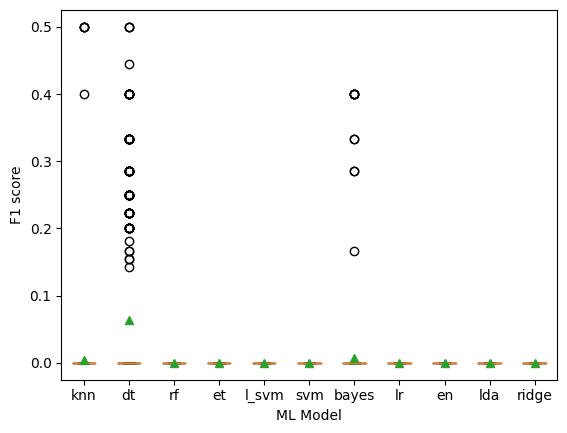

In [24]:
run_cv(X_train, y_train)

### Model ROCs

In [ ]:
def show_model_rocs():
  ax = plt.gca()
  fig = plt.gcf()
  fig.set_size_inches(9,5)

  models = get_models()
  for name, model in models.items():
    model.fit(X_train, y_train)
# M1_2_y_pred = M1_2.predict(X_test)
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)
  plt.ylabel("Sensitivity", fontsize=14)
  plt.xlabel("1-Specificity", fontsize=14)
  for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(14)
  plt.show()

In [ ]:
show_model_rocs()

## Pipelines

### Pipeline execution - GridSearchCV

In [ ]:
### KNN

parameters = {
    'selection__k': list(range(1, X.shape[1]+1)),
    'model__n_neighbors': list(range(2, 10)),
    'model__weights': ['uniform', 'distance'],
}

### LR

# parameters = {
#     # 'selection__k': list(range(1, X.shape[1]+1)),
#     'model__C': [1e-6, 1],
#     'model__penalty': ['l1', 'l2'],
#     'model__class_weight': [None, 'balanced'],
# }

### RIDGE

# parameters = {
#     # 'selection__k': list(range(1, X.shape[1]+1)),
#     'model__alpha': list(range(1,3)),
#     'model__tol': [0.0001, 0.001],
#     'model__class_weight': [None, 'balanced'],
# }

# parameters = {
#     'selection__k': list(range(1, X.shape[1]+1)),
#     'model__C': [1e-6, 1],
#     'model__kernel': ['linear', 'rbf'],
#     'model__class_weight': [None, 'balanced']
# }

# parameters = {
#     'selection__k': list(range(12, X.shape[1]+1)),
#     'model__C': [1e-6, 1],
#     'model__solver': ['liblinear', 'lbfgs'],
# }

# parameters = {
#     'selection__k': list(range(1, X.shape[1]+1)),
#     'model__solver': ['svd'],
# }

# parameters = {
#     # 'selection__k': list(range(1, X.shape[1]+1)),
#     'model__n_estimators': [10, 100],
#     'model__min_samples_leaf': [1, 5],
#     'model__min_impurity_decrease': [1e-6, 1],
# }

# parameters = {
#     # 'selection__k': list(range(1, X.shape[1]+1)),
#     'model__min_samples_leaf': [1],
#     'model__min_impurity_decrease': [1e-6],
# }


### EN

# parameters = {
#     # 'selection__k': list(range(16, X.shape[1]+1)),
#     'model__class_weight': [None, 'balanced'],
#     'model__l1_ratio': [0.1, 0.5, 0.9]
# }

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
grid = GridSearchCV(pipeline, parameters, cv=10, scoring="f1")
grid.fit(X_train, y_train)

print("the best estimator is \n {} ".format(grid.best_estimator_))
print("the best parameters are \n {}".format(grid.best_params_))

the best estimator is 
 Pipeline(steps=[('normalize', Normalizer()), ('kbest', SelectKBest(k=4)),
                ('model',
                 KNeighborsClassifier(n_neighbors=2, weights='distance'))]) 
the best parameters are 
 {'kbest__k': 4, 'model__n_neighbors': 2, 'model__weights': 'distance'}


### Pipeline execution - BayesSearchSV

In [ ]:
# pipeline class is used as estimator to enable
# search over different model types
pipe = Pipeline([
    ('model', SVC())
])

# single categorical value of 'model' parameter is
# sets the model class
# ConvergenceWarnings because the problem is not well-conditioned.
# linsvc_search = {
#     'model': [LinearSVC(max_iter=1000)],
#     'model__C': (1e-6, 1e+6, 'log-uniform'),
# }

# explicit dimension classes can be specified like this
# svc_search = {
#     'model': Categorical([SVC()]),
#     'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
#     'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#     'model__degree': Integer(1,8),
#     'model__kernel': Categorical(['linear', 'poly', 'rbf']),
# }

# rf_search = {
#     'model': Categorical([RandomForestClassifier()]),
#     'model__n_estimators': [10, 20, 50, 100],
#     'model__min_samples_leaf': [1, 2, 5],
#     'model__min_impurity_decrease': Real(1e-6, 1, prior='log-uniform'),
# }

# lr_search = {
#     'model': Categorical([LogisticRegression(penalty='l1')]),
#     # 'model__dual': [True, False],
#     'model__C': Real(1e-6, 1, prior='log-uniform'),
#     'model__solver': ['liblinear', 'lbfgs'],
#     'model__max_iter': [100, 500, 1000],
# }

# lr_search = {
#     'model': Categorical([LogisticRegression(penalty='l2')]),
#     'model__dual': [True, False],
#     'model__C': Real(1e-6, 1, prior='log-uniform'),
#     'model__solver': ['liblinear'],
#     'model__max_iter': [100, 500, 1000],
# }

# lr_search = {
#     'model': Categorical([LogisticRegression(penalty='elasticnet')]),
#     # 'model__dual': [True, False],
#     'model__C': Real(1e-6, 1, prior='log-uniform'),
#     'model__solver': ['liblinear', 'lbfgs'],
#     'model__max_iter': [100, 500, 1000],
# }

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(lr_search, 40)],
    cv=3
)

opt.fit(X_train, y_train)

print("best params: %s" % str(opt.best_params_))

## Performance metrics

In [ ]:
y_pred = grid.best_estimator_.named_steps['model'].predict(X_test)

In [ ]:
performance_metrics(grid.best_estimator_.named_steps['model'], y_test, y_pred)

## Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

imps = permutation_importance(grid.best_estimator_.named_steps['model'], X_test, y_test)
print(imps.importances_mean)

!!! ensure any features not selected by the implemented FS techniques have been removed from X_train and X_test before collating feature importances

In [ ]:
# RFI
rf = grid.best_estimator_.named_steps['model']
importance = rf.feature_importances_[0]

In [ ]:
# coefficients
importance = grid.best_estimator_.named_steps['model'].coef_[0]

In [ ]:
forest_importances = pd.Series(importance, index=features)
print(forest_importances.sort_values(ascending=False))

## ANN

In [ ]:
estimator = KerasClassifier(model=create_baseline, epochs=100, batch_size=5, verbose=0)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=1)
f1_score = cross_val_score(estimator, X, y, cv=cv, scoring='f1')
print("%.3f%% (%.3f%%)" % (f1_score.mean(), f1_score.std()))